In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date

## Importing CSVs

In [2]:
dfMovies = pd.read_csv(
    "content/IMDb movies w top_actor, top_actor_gender.csv",
    dtype={"year": str, "budget": str},
    sep="\t",
)
dfNames = pd.read_csv("content/IMDb names.csv")
dfRatings = pd.read_csv("content/IMDb ratings.csv")
dfTitlePrincipals = pd.read_csv("content/IMDb title_principals.csv")

In [3]:
dfMovies.shape

(85220, 24)

In [4]:
# Pick the columns from each of the datasets that should be used to train the ML algorithms
dfMovies = dfMovies[
    [
        "imdb_title_id",
        "title",
        "year",
        "genre",
        "duration",
        "country",
        "language",
        "director",
        "writer",
        "production_company",
        "budget",
        "top_actor",
        "top_actor_gender",
        "date_published"
    ]
]

dfRatings = dfRatings[
    ["imdb_title_id", "weighted_average_vote"]
]  # come back to this and include age groups/male/female votes
dfTitlePrincipals = dfTitlePrincipals[
    ["imdb_title_id", "ordering", "imdb_name_id"]
]  # should we get category? "actress"/"actor" (dont know if its necessary)

dfMovies = pd.merge(dfMovies, dfRatings, on=["imdb_title_id"])

dfMovies.shape

(85220, 15)

## Adding `actor_age` and `actor_age_at_release` to dfMovies

In [5]:
dfNames = dfNames.drop_duplicates("name")

dfMovies_Names = pd.merge(
    dfMovies,
    dfNames[
        [
            "name",
            "height",
            "children",
            "divorces",
            "spouses",
            "date_of_birth",
            "date_of_death",
        ]
    ],
    left_on=["top_actor"],
    right_on=["name"]
).drop(columns=["name"])

In [6]:
dfMovies_Names.shape

(85220, 21)

Merging the dfNames and dfMovies datasets. The result gives 22,623 rows.

In [7]:
def calc_age(row):
    try:
        born = datetime.strptime(row["date_of_birth"], "%Y-%m-%d").date()
        today = date.today()
        
        if pd.isnull(row["date_of_death"]):
            return today.year - born.year
        else:
            dead = datetime.strptime(row["date_of_death"], "%Y-%m-%d").date()
            return dead.year - born.year
    except:
        return None

In [8]:
def calc_age_at_release(row):
    try:
        born = datetime.strptime(row["date_of_birth"], "%Y-%m-%d").date()
        released = datetime.strptime(row["date_published"], "%Y-%m-%d").date()
        
        return released.year - born.year
    except:
        return None

Two functions to calculate the top actors age and the top actor age when the movie is released.

In [9]:
dfMovies_Names["actor_age_at_release"] = dfMovies_Names.apply(calc_age_at_release, axis=1)

In [10]:
dfMovies_Names["actor_age"] = dfMovies_Names.apply(calc_age, axis=1)

In [11]:
dfMovies_Names = dfMovies_Names.drop(columns=["date_of_birth", "date_of_death", "date_published"])

Dropping the features used to calculate the new features.

## Casting `year` and `budget` features

In [12]:
dfMovies_Names["year"] = dfMovies_Names["year"].astype(str).str.extract("(\d+)")
dfMovies_Names["budget"] = dfMovies_Names["budget"].astype(str).str.extract("(\d+)")

dfMovies_Names.year = pd.to_numeric(dfMovies_Names.year, errors="coerce").astype("Int64")
dfMovies_Names.budget = pd.to_numeric(dfMovies_Names.budget, errors="coerce").astype("Int64")

In [13]:
dfMovies_Names.dtypes

imdb_title_id             object
title                     object
year                       Int64
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
budget                     Int64
top_actor                 object
top_actor_gender          object
weighted_average_vote    float64
height                   float64
children                   int64
divorces                   int64
spouses                    int64
actor_age_at_release     float64
actor_age                float64
dtype: object

## Removing nulls and renaming

In [14]:
dfMovies_Names = dfMovies_Names.dropna()
df = dfMovies_Names

Dropping any rows with `NaN`.

## Encoding Functions

In [15]:
def encode_normal(df, col):
    return pd.get_dummies(df[col])

In [16]:
def other_col(row):
    if row.sum() == 0:
        return 1
    return 0

In [17]:
def encode_top_n(df, col, top):
    genre_encoded_df = pd.DataFrame()
    
    top_cat = pd.Index([f"{col}_{x}" for x in df[col].value_counts().index])[:top]
    genre_encoded_df = pd.get_dummies(df[col], prefix=col)[top_cat]

    genre_encoded_df["other_" + col] = genre_encoded_df.apply(other_col, axis=1)

    return genre_encoded_df

`encode_normal` returns the encoded column in a DataFrame.

`encode_top_n` return the top `n` most frequent values encoded in a DataFrame with an `other_` column for all the other values.

## Analyzing Categorical Features

### `genre`

In [18]:
df["genre"].value_counts()

Drama                         1148
Comedy                         812
Comedy, Drama                  590
Drama, Romance                 547
Comedy, Drama, Romance         545
                              ... 
Family, Fantasy, Music           1
Romance, Sport                   1
Action, Biography, History       1
Comedy, War, Drama               1
Action, Drama, Musical           1
Name: genre, Length: 666, dtype: int64

It looks like there are a significant number of movies that classify as the same genre.

In [19]:
genre_1_freq = (
    df["genre"].value_counts().where(df["genre"].value_counts() == 1).dropna()
)

print(genre_1_freq.shape)

genre_over_100_freq = (
    df["genre"].value_counts().where(df["genre"].value_counts() > 100).dropna()
)

print(genre_over_100_freq.shape)
print(genre_over_100_freq.sum())
print(f"{(genre_over_100_freq.sum()) / (df.shape[0])*100:.0f}%")

(223,)
(30,)
8585.0
55%


Specifically, there are 227 genres that only classify *one movie*. However there are 33 genres that classify over 100 movies. In total, those 33 genres account for 9,619 movies, which is over 50% of the movies in our dataset.

Therefore, it's probably safe to just OneHotEncode the existing values in `genres`.

Similar analysis of the following features are below.

### Other categorical features

In [20]:
to_encode = [
    "genre",
    "country",
    "language",
    "director",
    "writer",
    "production_company",
    "top_actor"
]


GENRE --------------------------------------------
Drama                         1148
Comedy                         812
Comedy, Drama                  590
Drama, Romance                 547
Comedy, Drama, Romance         545
                              ... 
Family, Fantasy, Music           1
Romance, Sport                   1
Action, Biography, History       1
Comedy, War, Drama               1
Action, Drama, Musical           1
Name: genre, Length: 666, dtype: int64

num of categories with 1 movie: 223

num of categories with over 100 movies: 30 which accounts for 8585


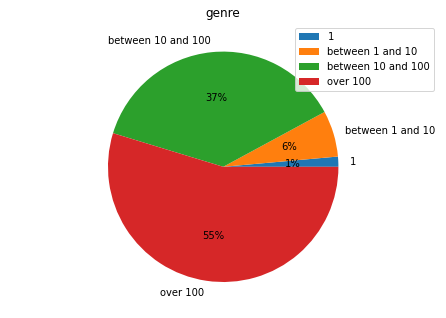


num of categories with > 100 movie: 30
accounts for 8585 or 55% of the dataset

COUNTRY --------------------------------------------
USA                               7904
UK                                 612
India                              470
Canada                             347
UK, USA                            303
                                  ... 
USA, Spain, France, Canada, UK       1
Sweden, Sri Lanka                    1
USA, Israel, Austria, Spain          1
United Arab Emirates                 1
USA, UK, Romania                     1
Name: country, Length: 1610, dtype: int64

num of categories with 1 movie: 1212

num of categories with over 100 movies: 17 which accounts for 11478


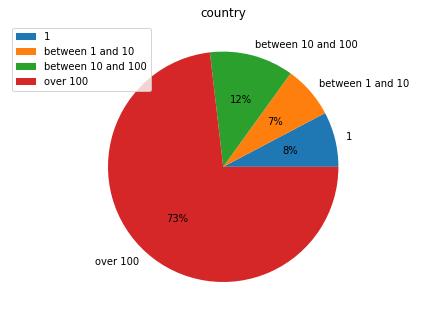


num of categories with > 100 movie: 17
accounts for 11478 or 73% of the dataset

LANGUAGE --------------------------------------------
English                                                        9108
English, Spanish                                                553
English, French                                                 350
French                                                          310
Spanish                                                         193
                                                               ... 
Cantonese, English, Vietnamese, French                            1
Mandarin, Japanese, English, Shanghainese, Hindi, Cantonese       1
English, German, Spanish, Latin                                   1
Spanish, Korean, Russian                                          1
English, Hungarian, Spanish                                       1
Name: language, Length: 1531, dtype: int64

num of categories with 1 movie: 1155

num of categories with over 100 mo

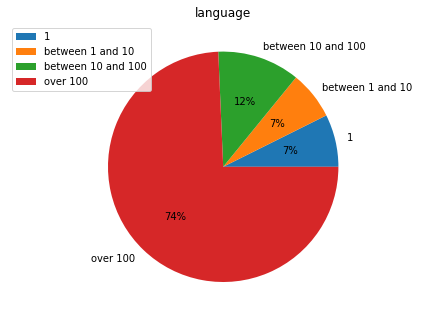


num of categories with > 100 movie: 13
accounts for 11660 or 74% of the dataset

DIRECTOR --------------------------------------------
Woody Allen         42
Clint Eastwood      36
Steven Spielberg    30
John Ford           28
Alfred Hitchcock    26
                    ..
Lara Shapiro         1
Kari Paljakka        1
Jean-Marc Minéo      1
Simon Kaijser        1
John Miller          1
Name: director, Length: 7957, dtype: int64

num of categories with 1 movie: 5388

num of categories with over 100 movies: 0 which accounts for 0


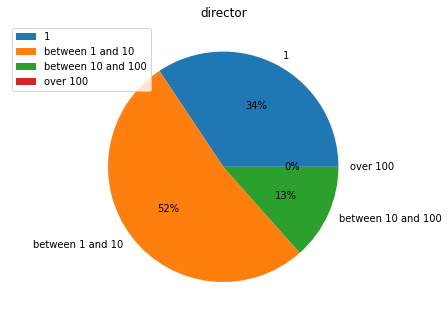


num of categories with > 100 movie: 0
accounts for 0 or 0% of the dataset

WRITER --------------------------------------------
Woody Allen                              34
John Hughes                              15
Joel Coen, Ethan Coen                    12
M. Night Shyamalan                       11
Larry Cohen                              11
                                         ..
Roger S. Baum, Randi Barnes               1
Daniel Frisch                             1
James Robert Johnston, Bennett Yellin     1
John Dahl, David W. Warfield              1
Claudio Caligari, Claudio Caligari        1
Name: writer, Length: 13678, dtype: int64

num of categories with 1 movie: 12467

num of categories with over 100 movies: 0 which accounts for 0


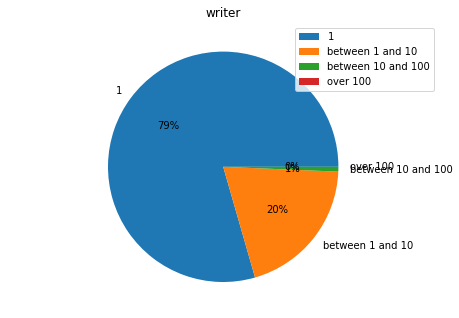


num of categories with > 100 movie: 0
accounts for 0 or 0% of the dataset

PRODUCTION_COMPANY --------------------------------------------
Metro-Goldwyn-Mayer (MGM)                             604
Warner Bros.                                          477
Universal Pictures                                    407
Twentieth Century Fox                                 398
Columbia Pictures                                     391
                                                     ... 
One Film                                                1
Neptune Productions                                     1
Creativos Asociados de Radio y Televisión (CARTEL)      1
Even Keel Productions LLC                               1
CoBo Fonds                                              1
Name: production_company, Length: 7082, dtype: int64

num of categories with 1 movie: 5408

num of categories with over 100 movies: 9 which accounts for 3046


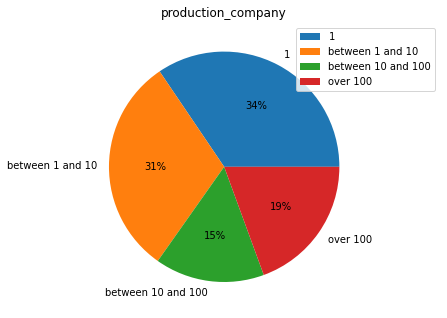


num of categories with > 100 movie: 9
accounts for 3046 or 19% of the dataset

TOP_ACTOR --------------------------------------------
Nicolas Cage       53
John Wayne         47
Robert De Niro     45
Tom Hanks          39
Clint Eastwood     39
                   ..
Diane Neal          1
Matti Pellonpää     1
Irina Björklund     1
Joana de Verona     1
Anne Marivin        1
Name: top_actor, Length: 6040, dtype: int64

num of categories with 1 movie: 3571

num of categories with over 100 movies: 0 which accounts for 0


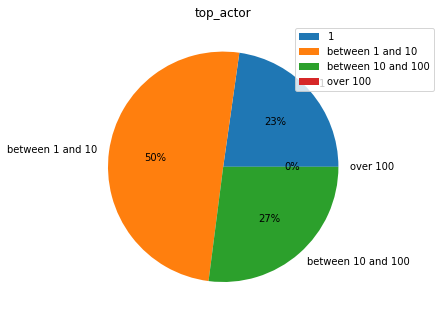


num of categories with > 100 movie: 0
accounts for 0 or 0% of the dataset


In [21]:
rows = df.shape[0]

labels = ["1", "between 1 and 10", "between 10 and 100", "over 100"]

for col in to_encode:
    data = []
    
    print(f"\n{col.upper()} --------------------------------------------")
    vc = df[col].value_counts()
    print(vc)

    filtered = vc.where(vc == 1).dropna()
    data.append((filtered.sum() / rows) * 100)

    print(f"\nnum of categories with 1 movie: {filtered.shape[0]}")

    filtered = vc.where((vc > 1) & (vc <= 10)).dropna()
    data.append((filtered.sum() / rows) * 100)

    filtered = vc.where((vc > 10) & (vc <= 100)).dropna()
    data.append((filtered.sum() / rows) * 100)

    filtered = vc.where(vc > 100).dropna()
    
    data.append((filtered.sum() / rows) * 100)

    print(
        f"\nnum of categories with over 100 movies: {filtered.shape[0]} which accounts for {filtered.sum():.0f}"
    )

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis("equal")

    ax.pie(data, labels=labels, autopct="%.0f%%")
    plt.title(col)
    plt.legend()
    plt.show()

    print(f"\nnum of categories with > 100 movie: {filtered.shape[0]}")
    print(
        f"accounts for {filtered.sum():.0f} or {(filtered.sum()/rows)*100:.0f}% of the dataset"
    )

## Encoding Categorical Columns

In [22]:
for col in to_encode:
    print(f"encoding {col}...")
    
    df = df.join(encode_top_n(df, col, 10))
    df = df.drop(columns=[col])
    
    print(df.dropna().shape)

encoding genre...
(15690, 30)
encoding country...
(15690, 40)
encoding language...
(15690, 50)
encoding director...
(15690, 60)
encoding writer...
(15690, 70)
encoding production_company...
(15690, 80)
encoding top_actor...
(15690, 90)


# To Do:
- Z-score scale the continuous values

## Encoding `year`

In [23]:
df = df.join(encode_normal(df, "year"))
df = df.drop(columns=["year"])

## Encoding `top_actor_gender`

In [24]:
df = df.join(encode_normal(df, "top_actor_gender"))
df = df.drop(columns=["top_actor_gender"])

In [25]:
df.shape

(15690, 198)

In [26]:
df.columns[:15]

Index(['imdb_title_id', 'title', 'duration', 'budget', 'weighted_average_vote',
       'height', 'children', 'divorces', 'spouses', 'actor_age_at_release',
       'actor_age', 'genre_Drama', 'genre_Comedy', 'genre_Comedy, Drama',
       'genre_Drama, Romance'],
      dtype='object')

In [27]:
df.to_csv("content/combined_data_10.csv", index=False)